<a href="https://colab.research.google.com/github/usmanqadeer1/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis_using_Multihead_attention_(transformers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive and unzip dataset

In [ ]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: unzip /content/drive/MyDrive/Colab Notebooks/TwitterSentimentAnalysis/archive.zip in same folder

# !unzip /content/drive/MyDrive/Colab\ Notebooks/TwitterSentimentAnalysis/archive.zip -d /content/drive/MyDrive/Colab\ Notebooks/TwitterSentimentAnalysis/

# !unzip "/content/drive/MyDrive/Colab Notebooks/TwitterSentimentAnalysis/glove.6B.100d.txt.zip" -d /content/drive/MyDrive/Colab\ Notebooks/TwitterSentimentAnalysis/


Archive:  /content/drive/MyDrive/Colab Notebooks/TwitterSentimentAnalysis/glove.6B.100d.txt.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/TwitterSentimentAnalysis/glove.6B.100d.txt  


# Get Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from joblib import dump
""

''

In [ ]:
column_names = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet']
train_data_ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TwitterSentimentAnalysis/twitter_training.csv', names =column_names)
test_data_ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TwitterSentimentAnalysis/twitter_validation.csv', names =column_names)
# train_data_ = pd.read_csv('/content/twitter_training.csv', names =column_names)
# test_data_ = pd.read_csv('/content/twitter_validation.csv', names =column_names)

In [ ]:
train_data_.head()

,Tweet ID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Data Preprocessing

In [ ]:
def preprocess(df):
    # Drop rows with missing values
    df = df.dropna()
    # remove duplicates
    df = df.drop_duplicates()
    # drop column Tweet_ID and Entity
    df = df.drop(['Tweet ID', 'Entity'], axis=1)
    # Encode labels
    label_encoder = LabelEncoder()
    df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
    return df
train_data = preprocess(train_data_)
test_data = preprocess(test_data_)

## Clean Text

In [ ]:
# Clean text, remove stop words

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Clean tweets
train_data['Tweet'] = train_data['Tweet'].apply(clean_text)
test_data['Tweet'] = test_data['Tweet'].apply(clean_text)

## Tokenize

In [ ]:
max_words = 20000
max_length = 100

# Tokenize tweets
tokenizer = Tokenizer(num_words=max_words, lower = True)
tokenizer.fit_on_texts(train_data['Tweet'])
word_index = tokenizer.word_index

# Convert tweets to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['Tweet'])
test_sequences = tokenizer.texts_to_sequences(test_data['Tweet'])

In [ ]:
vocab_size = len(word_index) + 1  # Add 1 for the out-of-vocabulary token
print("Vocabulary size:", vocab_size)

Vocabulary size: 39482


## Add padding

In [ ]:
# find second maximum length of sequence in train_sequences

# Find the length of each sequence
sequence_lengths = [len(seq) for seq in train_sequences]

# Sort the lengths in descending order
sorted_lengths = sorted(sequence_lengths, reverse=True)

# Get the second maximum length
second_max_length = sorted_lengths[2]

print("Second maximum length of sequence:", second_max_length)


Second maximum length of sequence: 99


In [ ]:
X_train_pad = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')

## One hot encoding

In [ ]:
y_train = train_data['Sentiment']
y_test = test_data['Sentiment']

In [ ]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Training

## Training with Multihead Attention

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization, Dropout
def create_multihead_attention_model(input_shape, num_heads=8, d_model=128, num_classes=4): # Change num_classes to 4
    inputs = Input(shape=input_shape)

    # Embedding layer
    x = Embedding(input_dim=20000, output_dim=d_model)(inputs)

    # Multihead Attention Layer
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, output_shape=d_model)
    attention_output = attention_layer(x, x)
    attention_output = Dropout(0.1)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)


    # Global Average Pooling
    x = GlobalAveragePooling1D()(attention_output)

    # Fully connected layer
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x) # Now outputs to 4 neurons

    model = Model(inputs=inputs, outputs=outputs)

    return model
input_shape = (100,)  # The shape of your padded sequences
model = create_multihead_attention_model(input_shape)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 100, 128)             2560000   ['input_7[0][0]']             
                                                                                                  
 multi_head_attention_5 (Mu  ((None, 100, 128),           527488    ['embedding_7[0][0]',         
 ltiHeadAttention)            (None, 8, 100, 100))                   'embedding_7[0][0]']         
                                                                                                  
 dropout_7 (Dropout)         (None, 100, 128)             0         ['multi_head_attention_5

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with a reduced batch size
model.fit(X_train_pad, y_train_onehot, epochs=10, batch_size=128, validation_data=(X_test_pad, y_test_onehot))

In [ ]:
# Save the trained model
model.save('sentiment_model_transformer.h5')
# dump(tokenizer, 'tokenizer1.joblib')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Training with multihead attention with skip connections (Transformer Encoder)

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization, Dropout, Add
def create_multihead_attention_model_skip_conns(input_shape, num_heads=8, d_model=128, num_classes=4): # Change num_classes to 4
    inputs = Input(shape=input_shape)

    # Embedding layer
    x = Embedding(input_dim=20000, output_dim=d_model)(inputs)

    # Multihead Attention Layer
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, output_shape=d_model)
    attention_output = attention_layer(x, x)
    attention_output = Dropout(0.1)(attention_output)

    # Add layer with skip connection
    x = Add()([x, attention_output])

    # Norm layer
    attention_output = LayerNormalization(epsilon=1e-6)(x)

     # Feed-Forward Layer
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Another Skip Connection and Layer Normalization
    x = Add()([x, attention_output])  # Using previous attention_output for consistency
    x = LayerNormalization(epsilon=1e-6)(x)


    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x) # Now outputs to 4 neurons

    model = Model(inputs=inputs, outputs=outputs)

    return model
input_shape = (100,)  # The shape of your padded sequences
model = create_multihead_attention_model(input_shape)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 100, 128)             2560000   ['input_9[0][0]']             
                                                                                                  
 multi_head_attention_7 (Mu  ((None, 100, 128),           527488    ['embedding_9[0][0]',         
 ltiHeadAttention)            (None, 8, 100, 100))                   'embedding_9[0][0]']         
                                                                                                  
 dropout_11 (Dropout)        (None, 100, 128)             0         ['multi_head_attention_7

In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit(X_train_pad, y_train_onehot, epochs=10, batch_size=128, validation_data=(X_test_pad, y_test_onehot))

Epoch 1/10
560/560 [==============================] - 42s 70ms/step - loss: 1.3691 - accuracy: 0.3127 - val_loss: 1.1240 - val_accuracy: 0.4980
Epoch 2/10
560/560 [==============================] - 24s 43ms/step - loss: 0.7448 - accuracy: 0.7106 - val_loss: 0.3032 - val_accuracy: 0.9010
Epoch 3/10
560/560 [==============================] - 23s 41ms/step - loss: 0.3838 - accuracy: 0.8545 - val_loss: 0.2175 - val_accuracy: 0.9300
Epoch 4/10
560/560 [==============================] - 22s 40ms/step - loss: 0.3036 - accuracy: 0.8812 - val_loss: 0.2247 - val_accuracy: 0.9320
Epoch 5/10
560/560 [==============================] - 22s 39ms/step - loss: 0.2668 - accuracy: 0.8923 - val_loss: 0.2244 - val_accuracy: 0.9350
Epoch 6/10
560/560 [==============================] - 23s 40ms/step - loss: 0.2419 - accuracy: 0.9006 - val_loss: 0.2385 - val_accuracy: 0.9350
Epoch 7/10
560/560 [==============================] - 21s 38ms/step - loss: 0.2222 - accuracy: 0.9086 - val_loss: 0.2093 - val_accuracy:

In [46]:
model.save('c')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
# in the train_data which sentiment has been given which label
label_encoder = LabelEncoder()
label_encoder.fit_transform(train_data_['Sentiment'])
for sentiment, label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
  print(f"Sentiment: {sentiment}, Label: {label}")



Sentiment: Irrelevant, Label: 0
Sentiment: Negative, Label: 1
Sentiment: Neutral, Label: 2
Sentiment: Positive, Label: 3


# Evaluation

In [48]:
# load model and compute accuracy, recall, precision, f1score and confusion matrix for test_data

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('sentiment_model_transformer_skip.h5')

# Make predictions on the test data
y_pred_probs = loaded_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)


32/32 [==============================] - 0s 7ms/step
Accuracy: 0.951
Precision: 0.9515441181801775
Recall: 0.951
F1-score: 0.950913987292459
Confusion Matrix:
 [[168   0   0   4]
 [  0 256   3   7]
 [ 10   7 261   7]
 [  0   7   4 266]]


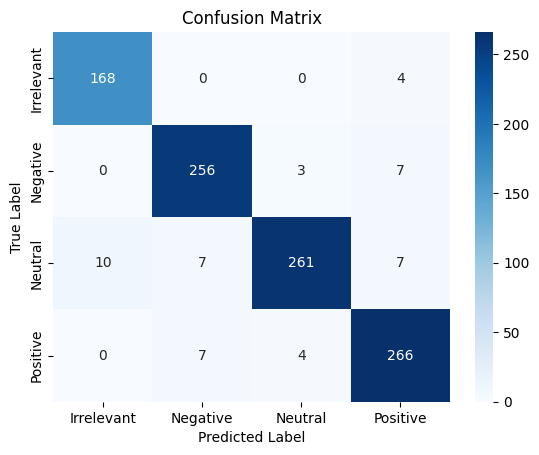

In [51]:
# print conf_matrix using sns and label 0, 1, 2 ,3 as Irrelevant, Negative, Neutral and Positive

import seaborn as sns
import matplotlib.pyplot as plt

# ... (preceding code)

# Plot confusion matrix using seaborn
labels = ['Irrelevant', 'Negative', 'Neutral', 'Positive']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


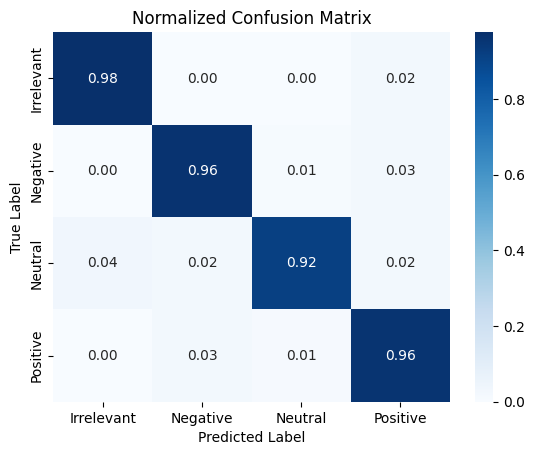

In [52]:
# Now print conf_matrix as same as above but showing fractions

import matplotlib.pyplot as plt
import numpy as np
# Plot confusion matrix using seaborn with fractions
labels = ['Irrelevant', 'Negative', 'Neutral', 'Positive']
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
# show count of unique Sentiments in test_data_

# Count unique Sentiments in test_data_
sentiment_counts = test_data_['Sentiment'].value_counts()
print(sentiment_counts)


Sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64


In [ ]:
sentiment_counts = test_data['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
2    285
3    277
1    266
0    172
Name: count, dtype: int64


# Visualize Embeddings

In [ ]:
# visualize embeddings in loaded_model in 3d

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get the embedding layer's weights
embedding_layer = loaded_model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

# Apply t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embedding_weights)

# Visualize the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# For simplicity, plot a subset of the embeddings
num_words_to_plot = 100
for i in range(num_words_to_plot):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], s=list(word_index.keys())[i])

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title('3D Visualization of Word Embeddings')
plt.show()


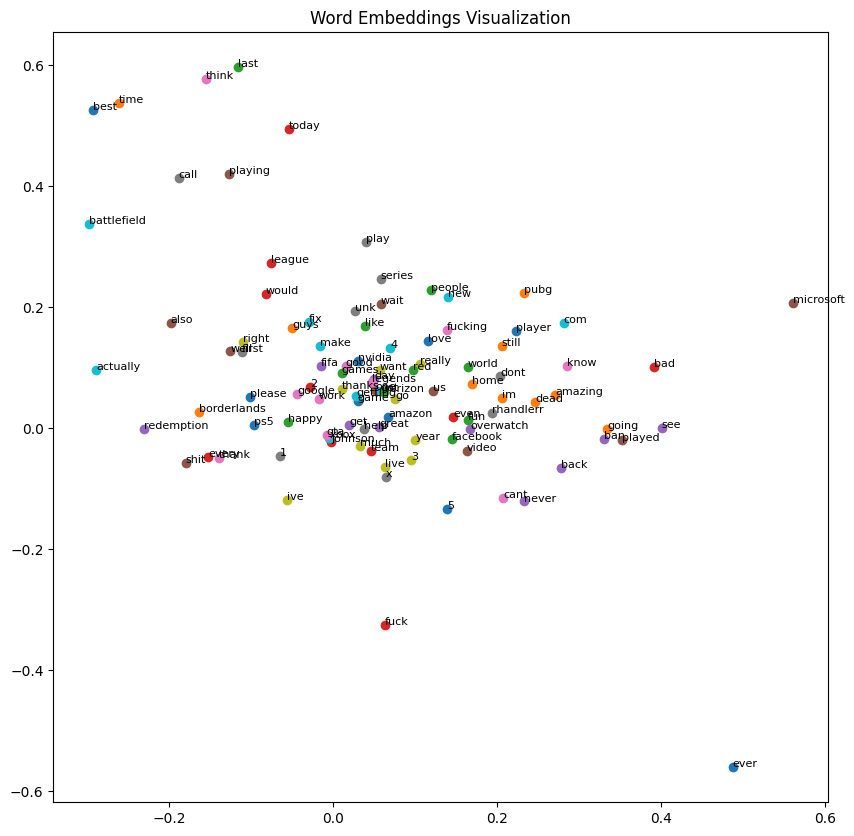

In [ ]:
# visualize embeddings in loaded_model

import matplotlib.pyplot as plt
# Extract embeddings from the loaded model
embeddings = loaded_model.layers[0].get_weights()[0]

# Reduce dimensionality for visualization (e.g., using PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the reduced embeddings
plt.figure(figsize=(10, 10))
for i, word in enumerate(tokenizer.word_index):
    if i < 100:  # Limit to the first 100 words for clarity
        x, y = reduced_embeddings[i]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), fontsize=8)

plt.title('Word Embeddings Visualization')
plt.show()
